# Events analysis

In [1]:
import sys
import os
parent_folder_path = os.path.abspath(os.path.join(os.getcwd(), "..", "utils"))
sys.path.append(parent_folder_path)
from utils import arrify_string_columns, deep_copy, IncidentStats
data_folder = os.path.join("..", "data")

import numpy as np
import pandas as pd
import math
import dataframe_image as dfi
import matplotlib.pyplot as plt
from  matplotlib.ticker import MaxNLocator 
import seaborn as sns
from collections import Counter

In [2]:
original_df = pd.read_csv(os.path.join(data_folder, "time_sorted_table.csv"), sep=';', index_col=0)
arrify_string_columns(original_df)

## Preprocessing

In [3]:
non_sorted_df = pd.read_csv(os.path.join(data_folder, "sncb_data_challenge.csv"), sep=';', index_col=0)
arrify_string_columns(non_sorted_df)

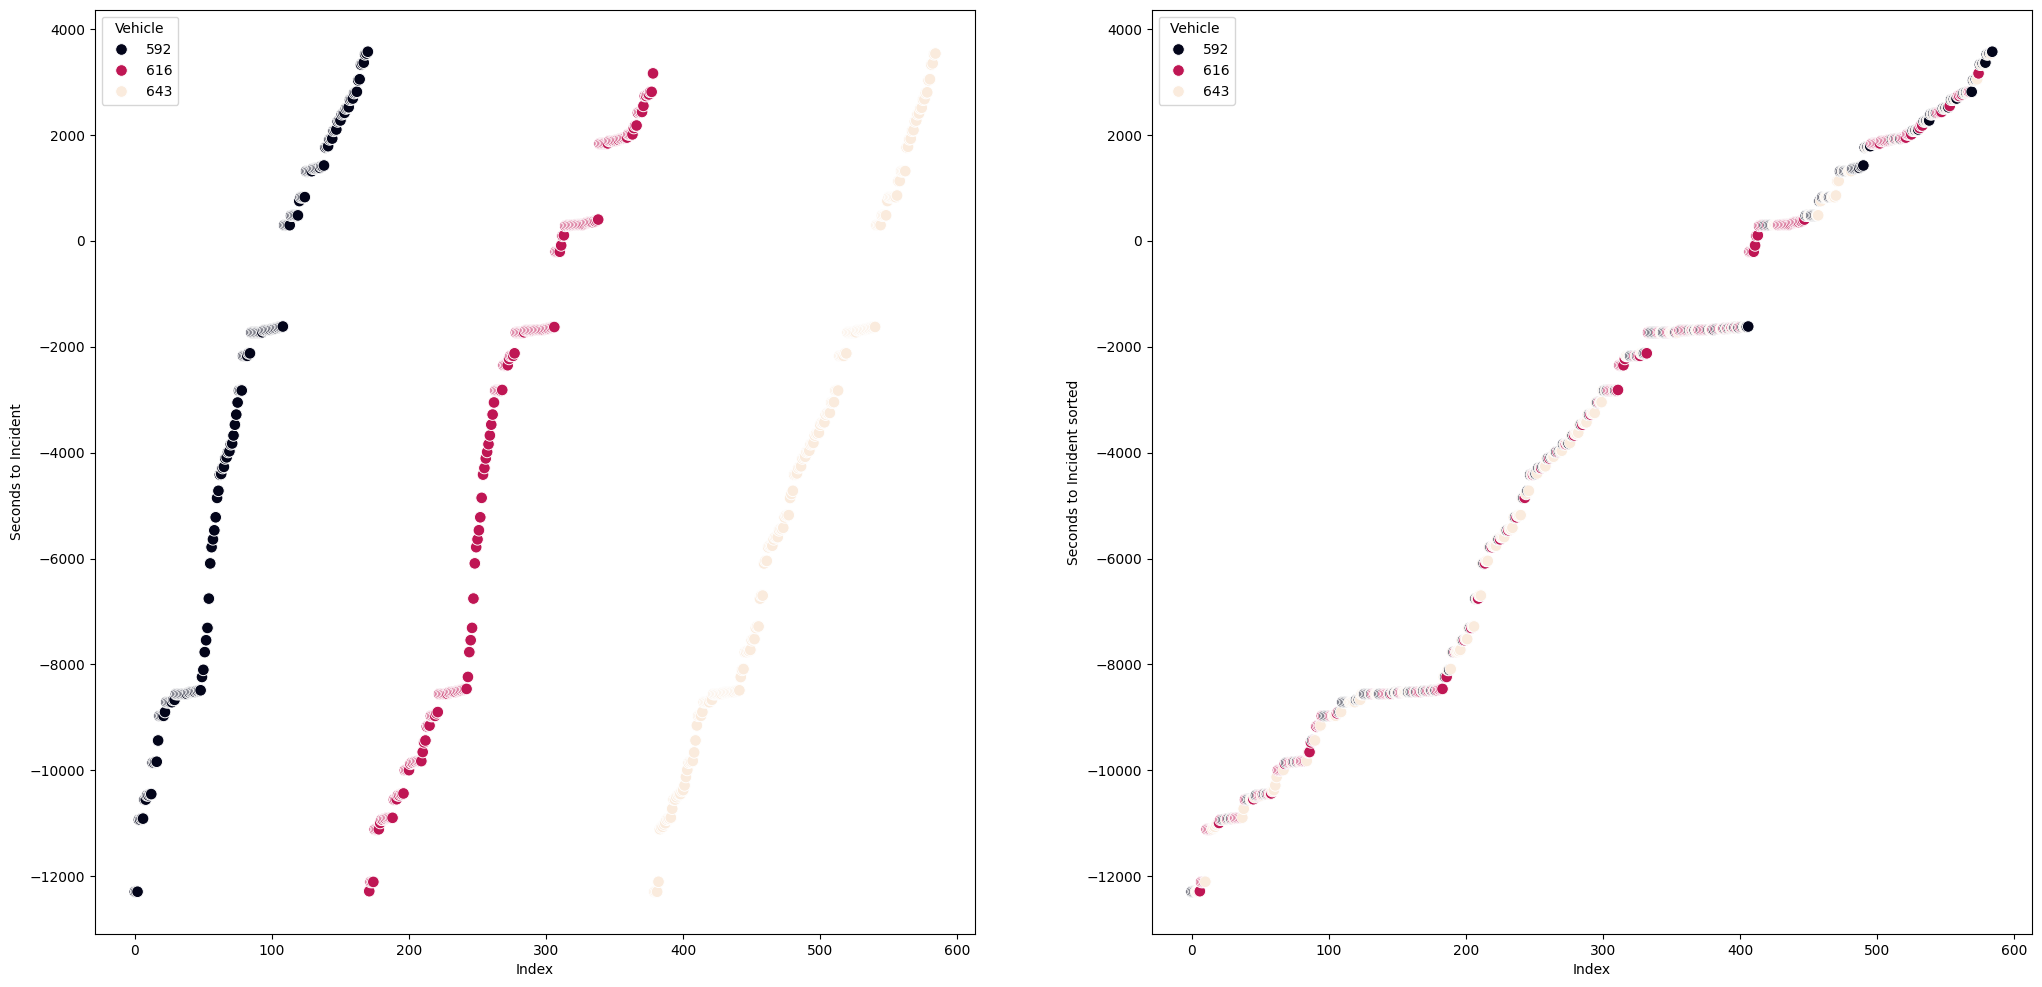

In [4]:
plt.style.use("default")
row = non_sorted_df.loc[2]
row_sorted = original_df.loc[2]
x = np.arange(0, len(row.seconds_to_incident_sequence))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
y = [x for x in row.seconds_to_incident_sequence]
y_sorted = [x for x in row_sorted.seconds_to_incident_sequence]
dict = {"Index": x, "Seconds to Incident": y, "Seconds to Incident sorted": y_sorted, 'Vehicle': row.vehicles_sequence, 'Vehicle ': row_sorted.vehicles_sequence}
df_vis = pd.DataFrame(dict)

sns.scatterplot(data=df_vis, x='Index', y='Seconds to Incident', hue='Vehicle', ax=ax1, palette='rocket', s=70)
sns.scatterplot(data=df_vis, x='Index', y='Seconds to Incident sorted', hue='Vehicle ', ax=ax2, palette='rocket', s=70)
#plt.style.use("dark_background")
#fig.savefig("preprocessing.png", transparent=True)
plt.show()

## General analysis

In [5]:
IS = IncidentStats(original_df)
df = deep_copy(original_df)

df['num_events'] = df['events_sequence'].apply(lambda x: len(x))
df['num_vehicles'] = df['vehicles_sequence'].apply(lambda x: len(set(x)))

In [6]:
print(df.num_events.describe())
print()
print(df.num_vehicles.describe())
print()

count    1011.000000
mean      553.197824
std       314.852092
min        10.000000
25%       307.500000
50%       554.000000
75%       746.000000
max      2407.000000
Name: num_events, dtype: float64

count    1011.000000
mean        1.748764
std         0.724525
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: num_vehicles, dtype: float64



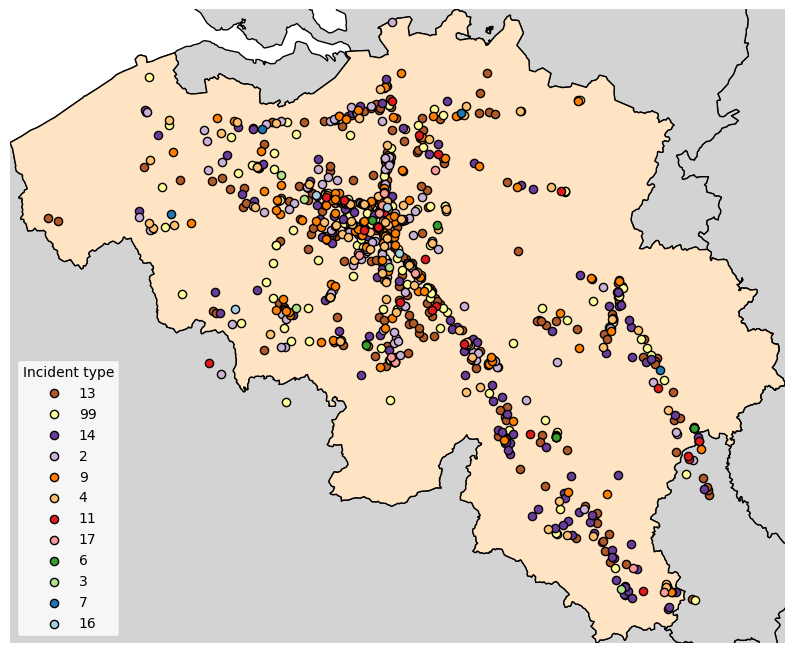

In [7]:
IS.get_geospatial_summary(original_df)

In [8]:
IS.get_stats_incidents(original_df)

,incident_type,count,percentage,count_percentage_on_total
0,2,119,11.770524,100.0
1,3,5,0.494560,100.0
2,4,78,7.715134,100.0
3,6,6,0.593472,100.0
4,7,4,0.395648,100.0
5,9,117,11.572700,100.0
6,11,26,2.571711,100.0
7,13,318,31.454006,100.0
8,14,149,14.737883,100.0
9,16,4,0.395648,100.0


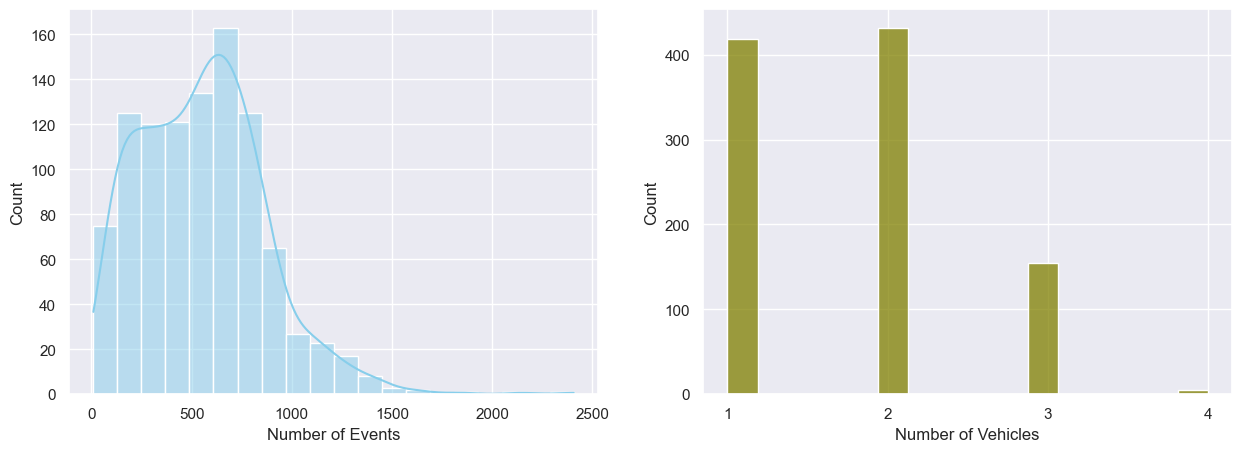

In [9]:
sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x="num_events", bins=20, color='skyblue', ax=axs[0], kde=True)
axs[0].set(xlabel='Number of Events')
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
sns.histplot(data=df, x="num_vehicles", color='olive', ax=axs[1])
axs[1].set(xlabel='Number of Vehicles')

plt.savefig('counts.png', bbox_inches='tight', transparent=True)
plt.show()

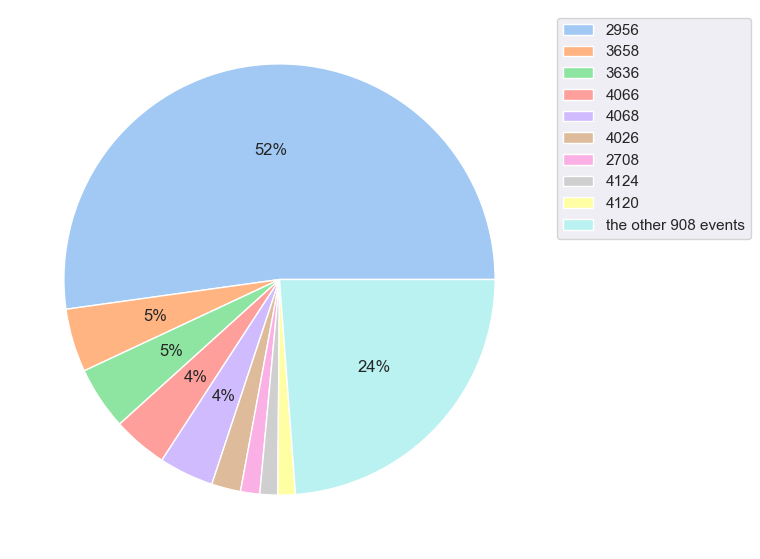

,event,counts_on_total
78,2956,291975
80,3658,26608
79,3636,26491
26,4066,23018
23,4068,22951
...,...,...
792,820,1
785,3584,1
784,1634,1
776,1664,1


In [10]:
all_events = np.concatenate(df.events_sequence)

event_counts = pd.DataFrame.from_dict(Counter(all_events), orient='index', columns=['counts_on_total'])
event_counts = event_counts.reset_index(names='event').sort_values(by='counts_on_total', ascending=False)

first_x = 9

counts_first_x = event_counts[:first_x].copy()
counts_others = pd.DataFrame(data = {
    'event': [f'the other {event_counts.shape[0] - first_x} events'],
    'counts_on_total': [event_counts.counts_on_total[first_x:].sum()]
}) 

def autopct_more_than_3(pct):
    return ('%1.f%%' % pct) if pct > 3 else ''

event_counts_summarized = pd.concat([counts_first_x, counts_others])
colors = sns.color_palette('pastel')
fig, ax = plt.subplots(figsize=(7, 7))
plt.pie(event_counts_summarized.counts_on_total, autopct=autopct_more_than_3, colors=colors)
ax.legend(event_counts_summarized.event, loc='best', bbox_to_anchor=(1,1))
plt.savefig('event_distribution.png', bbox_inches='tight', transparent=True)
plt.show()

display(event_counts)

,incident_type,count,percentage,count_percentage_on_total
0,2,36,10.588235,30.252101
1,3,1,0.294118,20.000000
2,4,38,11.176471,48.717949
3,6,3,0.882353,50.000000
4,7,3,0.882353,75.000000
5,9,59,17.352941,50.427350
6,11,21,6.176471,80.769231
7,13,54,15.882353,16.981132
8,14,67,19.705882,44.966443
9,17,5,1.470588,50.000000


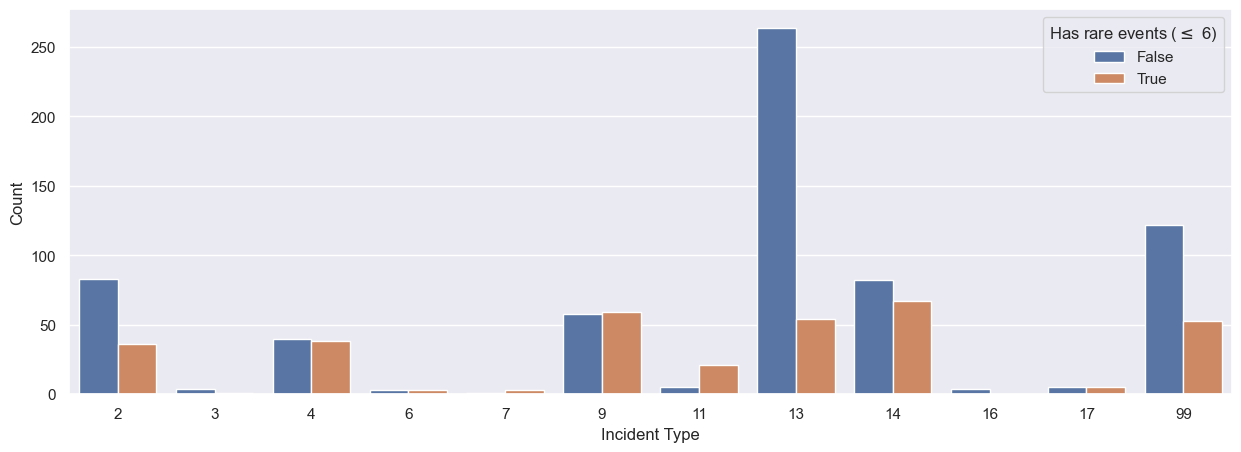

In [11]:
rare_events = set([event for event in event_counts[event_counts.counts_on_total <= 6].event])
tuples_with_rare_events = df.apply(lambda x: set(x.events_sequence).intersection(rare_events), axis=1)
df['rare_set'] = tuples_with_rare_events
df['how_many_rare'] = tuples_with_rare_events.apply(len)
df['has_rare'] = tuples_with_rare_events.apply(lambda x: len(x) != 0)
df_with_rare_events = df[df.how_many_rare > 0]
stats = IS.get_stats_incidents(df_with_rare_events)
#IS.get_geospatial_summary(df_with_rare_events)
#IS.get_geospatial_summary(df_with_rare_events[df_with_rare_events.incident_type == 11])
#df_count_rare = df_with_rare_events[['how_many_rare', 'incident_type']]
#pd.merge(stats, df_count_rare.groupby('incident_type').max(), on='incident_type')
display(stats)
plt.figure(figsize=(15,5))
sns.countplot(df, x='incident_type', hue='has_rare', stat='count')
plt.legend(title="Has rare events ($\leq$ 6)")
plt.xlabel("Incident Type")
plt.ylabel("Count")
plt.savefig('rare_events.png', bbox_inches='tight', transparent=True)
plt.show()

,event,counts_on_total
78,2956,291975
80,3658,26608
79,3636,26491
26,4066,23018
23,4068,22951
...,...,...
792,820,1
785,3584,1
784,1634,1
776,1664,1


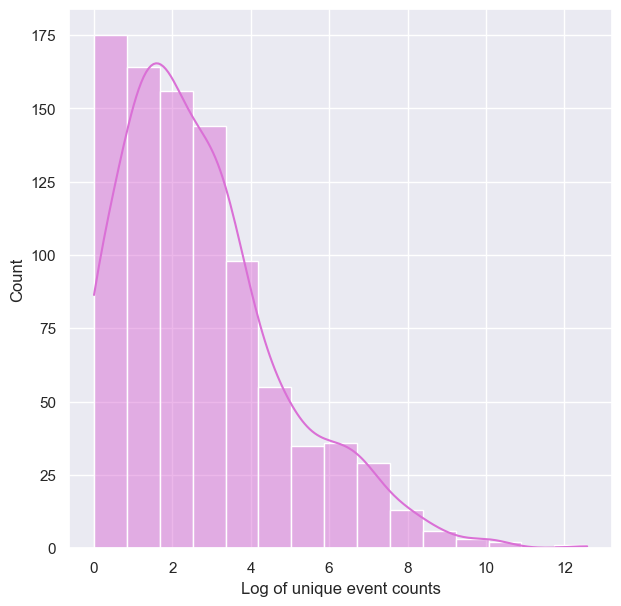

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
display(event_counts)
sns.histplot(data=event_counts.counts_on_total.apply(lambda x: math.log(x)), bins=15, color='orchid', ax=ax, kde=True)
ax.set_xlabel('Log of unique event counts')
plt.show()

## Electricity Analysis

In [13]:
df[['both_true', 'both_false']] = df.apply(
    lambda row: pd.Series({
        'both_true': [r1 and r2 for r1, r2 in zip(row.dj_ac_state_sequence, row.dj_dc_state_sequence)],
        'both_false': [not r1 and not r2 for r1, r2 in zip(row.dj_ac_state_sequence, row.dj_dc_state_sequence)]
    }), 
    axis=1
)

We can see that at any time no train is connected to both AC and DC

In [14]:
df[df['both_true'].apply(lambda x: any(x))].shape[0]

0

In [15]:
#df[df['both_false'].apply(lambda x: any(x))].size
df[df['both_false'].apply(lambda x: any(x))].shape[0]

724

In [16]:
always_on_battery = deep_copy(df[df['both_false'].apply(lambda x: all(x))])

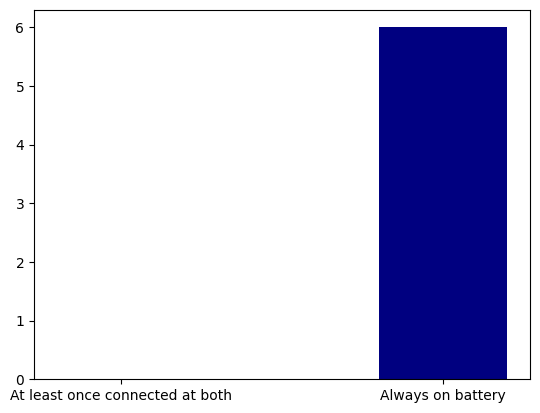

In [17]:
plt.style.use("default")
electricity_analysis = {}
electricity_analysis['At least once connected at both'] = df[df['both_true'].apply(lambda x: any(x))].shape[0]
electricity_analysis['Always on battery'] = always_on_battery.shape[0]
electricity_df = pd.DataFrame.from_dict(electricity_analysis, orient='index', columns=['Count'])
plt.bar(electricity_analysis.keys(), electricity_analysis.values(), width=0.4, color='navy')
plt.savefig('electricity_on_off.png', bbox_inches='tight', transparent=True)
plt.show()

In [18]:
df.loc[always_on_battery.index]

,incident_id,vehicles_sequence,events_sequence,seconds_to_incident_sequence,approx_lat,approx_lon,train_kph_sequence,dj_ac_state_sequence,dj_dc_state_sequence,incident_type,num_events,num_vehicles,rare_set,how_many_rare,has_rare,both_true,both_false
155,4440081,"[1090, 1090, 1090, 1090, 1090, 1090, 1090, 109...","[2492, 3986, 4002, 1032, 1082, 1132, 2852, 411...","[-14344, -14291, -13960, -13960, -13960, -1396...",50.956162,5.091324,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",14,218,1,{},0,False,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."
486,4455925,"[704, 704, 704, 704, 704, 704, 704, 704, 704, ...","[4002, 2852, 4110, 2854, 4092, 4094, 4026, 270...","[-1820, -1818, -1818, -1816, -1815, -1815, -18...",50.894239,4.409328,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",14,78,1,{2574},1,True,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."
621,4461601,"[1047, 1047, 1047, 1047, 1047, 1047, 1047, 104...","[4396, 2288, 2462, 4394, 2464, 2288, 2742, 402...","[-12007, -11610, -11610, -11610, -11609, -1158...",49.678457,5.816943,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",99,344,1,"{2596, 2372, 2374, 2538, 2514, 2516, 4188}",7,True,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."
759,4468195,"[1027, 1027, 1027, 1027, 1027, 1027, 1027, 102...","[4004, 2852, 4110, 2854, 4092, 4094, 4026, 249...","[-13237, -13235, -13235, -13233, -13232, -1323...",50.618932,5.573920,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",14,78,1,{2520},1,True,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."
825,4601001,"[1009, 1009, 1009, 1009, 1009, 1009, 1009, 100...","[4002, 4032, 4028, 4026, 4110, 2852, 2854, 410...","[-7561, -7561, -7560, -7559, -7559, -7558, -75...",50.189588,5.953584,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",6,45,1,{},0,False,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."
917,4606573,"[650, 650, 650, 650, 650, 650, 650, 650, 650, ...","[4002, 4092, 4094, 2852, 4110, 2854, 4026, 398...","[-2445, -2444, -2444, -2442, -2442, -2440, -24...",51.012874,3.779166,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",99,119,1,{},0,False,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."


In [19]:
always_on_battery['reversed_time'] = always_on_battery.seconds_to_incident_sequence.map(lambda x: x[::-1])

In [20]:
def highlight(s):
   if s.reversed_time[0] < 0:
       return ['background-color: #ffe6e6'] * len(s)

reduced_aob = always_on_battery[['incident_id', 'reversed_time']]
display(reduced_aob)

,incident_id,reversed_time
155,4440081,"[-3760, -3825, -3837, -3842, -3868, -3875, -38..."
486,4455925,"[-26, -230, -230, -297, -305, -305, -321, -377..."
621,4461601,"[3122, 1568, 1547, 1546, 1342, 1342, 1312, 130..."
759,4468195,"[591, 401, 401, 398, 331, 330, 330, 314, 313, ..."
825,4601001,"[-6305, -6305, -6354, -6372, -6423, -6428, -64..."
917,4606573,"[1637, 1633, 1633, 1633, 1633, 1632, 1632, 163..."


Index([155, 486, 621, 759, 825, 917], dtype='int64')


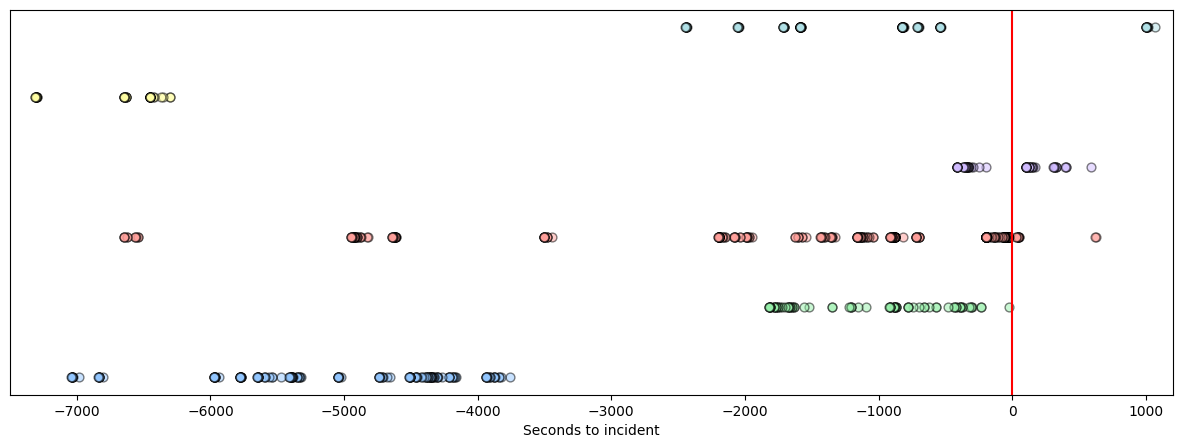

In [21]:
plt.style.use('seaborn-v0_8-pastel')
x = reduced_aob.reversed_time.values
y = np.arange(1, reduced_aob.shape[0] + 1)
plt.figure(figsize=(15, 5))
for y, xs in enumerate(x):
    plt.scatter(xs, np.full(len(xs), y), s=40, edgecolors='black', alpha = 0.5)

print(reduced_aob.index)
plt.xlim((-7500, 1200))
plt.axvline(0, color='red')
plt.xlabel("Seconds to incident")
plt.yticks([])
plt.savefig('always_on_battery_timeline.png', bbox_inches='tight', transparent=True)
plt.show()

## Events that stops logging before instant 0

In [22]:
def get_records_that_stopped_before_epsilon(dataframe, epsilon):
    return dataframe[dataframe.apply(lambda x: x.seconds_to_incident_sequence[-1] < epsilon, axis=1)]

Number of rows that stopped logging from 1 seconds before the zero: 18
Number of rows that stopped logging from 2 seconds before the zero: 18
Number of rows that stopped logging from 4 seconds before the zero: 18
Number of rows that stopped logging from 9 seconds before the zero: 18
Number of rows that stopped logging from 19 seconds before the zero: 17
Number of rows that stopped logging from 40 seconds before the zero: 16
Number of rows that stopped logging from 86 seconds before the zero: 15
Number of rows that stopped logging from 181 seconds before the zero: 12
Number of rows that stopped logging from 380 seconds before the zero: 11
Number of rows that stopped logging from 799 seconds before the zero: 9
Number of rows that stopped logging from 1680 seconds before the zero: 6
Number of rows that stopped logging from 3530 seconds before the zero: 4
Number of rows that stopped logging from 7419 seconds before the zero: 1
Number of rows that stopped logging from 13329 seconds before t

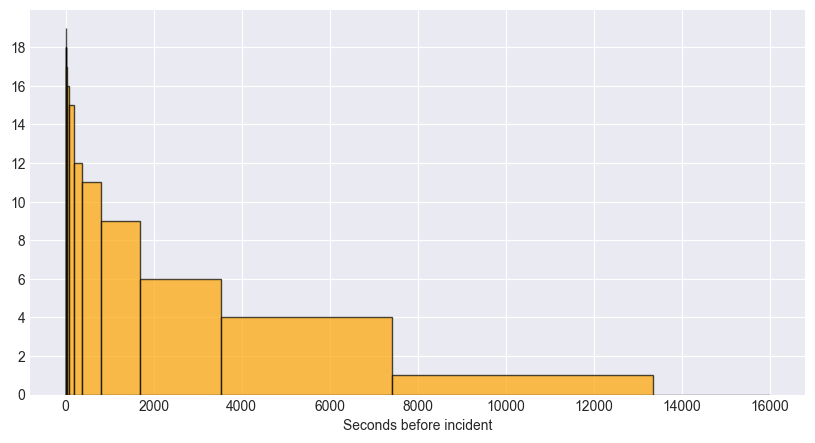

In [23]:
plt.style.use("seaborn-v0_8-darkgrid")
records_stop_log_before_0 = get_records_that_stopped_before_epsilon(df, 0)
last_second_logged = records_stop_log_before_0['seconds_to_incident_sequence'].apply(lambda x: -x[-1])

quarter = np.logspace(0, 15, num=15, base=2, dtype='int')
quarter[-2] = max(last_second_logged) + 1
quarter[-1] = 16000

for epsilon in quarter: 
    print(f"Number of rows that stopped logging from {epsilon} seconds before the zero: {len(get_records_that_stopped_before_epsilon(df, -epsilon))}")

fig, ax = plt.subplots(figsize=(10, 5))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.hist(last_second_logged, bins=quarter, color='orange', edgecolor='black', alpha=0.7, cumulative=-1)
plt.xlabel("Seconds before incident")
plt.savefig('events_stop.png', bbox_inches='tight', transparent=True)

plt.show()

What shall we do with these records? 

We can see that they say nothing about the type of incident

In [24]:
IS.get_stats_incidents(get_records_that_stopped_before_epsilon(df, -600))

,incident_type,count,percentage,count_percentage_on_total
0,4,1,10.0,1.282051
1,6,1,10.0,16.666667
2,13,1,10.0,0.314465
3,14,3,30.0,2.013423
4,99,4,40.0,2.285714


## Speed analysis

Delta lists of an attribute is the list that has for elements the difference between one element and its preceding one in the attribute list 

The element 0 is the initial value

In [25]:
def kph_to_ms(speed):
    return speed/3.6


def calculate_deltas(row):
    deltas = list.copy(row)
    for idx in range(len(row)):
        if idx != 0:
            deltas[idx] = row[idx] - row[idx - 1]
    return deltas


df['speed'] = df.train_kph_sequence.apply(lambda speeds: [kph_to_ms(speed) for speed in speeds])
df['speed_delta'] = df.speed.apply(lambda speed: calculate_deltas(speed))
df['time_delta'] = df.seconds_to_incident_sequence.apply(lambda time: calculate_deltas(time))

We calculate the acceleration as $\frac{\Delta v}{\Delta t}$.

If $\Delta t = 0$ and $\Delta v \neq 0$ it means that there was a variation of speed in less than a second, we will specify with $\epsilon$ the possible speed variation allowed after which we consider what we are seeing as an error and assign it an immensely high value for the acceleration, marking it as a possible error

In [26]:
MAX_ACCELERATION = 9_999_999_999_999

def calculate_acceleration(delta_speed, delta_time):
    epsilon = 5 
    acceleration = 0.0
    if delta_time != 0:
        acceleration = delta_speed / delta_time
    if delta_time == 0 and abs(delta_speed) > epsilon:
        acceleration = MAX_ACCELERATION 
    return acceleration
        

df['acceleration'] = df.apply(
    lambda row: [calculate_acceleration(speed, time) for speed, time in zip(row.speed_delta, row.time_delta)], 
    axis=1
)

df.acceleration = df.acceleration.apply(lambda row: row[1:])

We remove the first element of the acceleration, first because it has no meaning given that it is given by the division of the initial speed and time but also because in this way we are giving the acceleration meaning to the first value of each couple.

So given elements $i$ and $i+1$, this will be satisfied: $v_{i+1} = v_{i} + a_i  \Delta t_{i+1}$

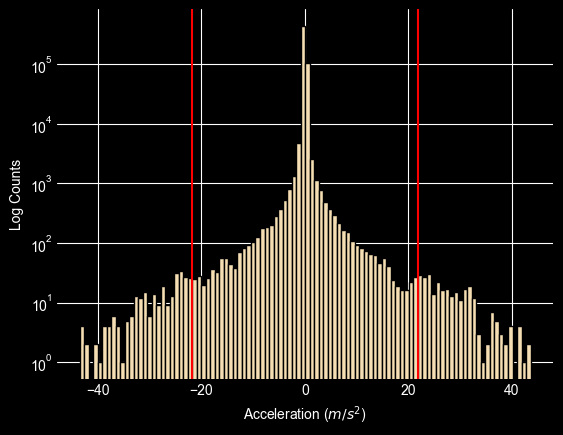

Possible high deceleration value is -21.736111111111107
Possible high acceleration value is 21.84722222222223


In [27]:
plt.style.use("dark_background")
all_accelerations = np.concatenate(df.acceleration.values) 
all_accelerations = np.delete(all_accelerations, np.where(all_accelerations == MAX_ACCELERATION))

max_value = np.max(all_accelerations)
min_value = np.min(all_accelerations)
quarter = (max_value - min_value)/4
high_deceleration = min_value + quarter
high_acceleration = min_value + 3*quarter
plt.hist(all_accelerations, bins=100, edgecolor='black', color='wheat')
plt.axvline(high_deceleration, color='red')
plt.axvline(high_acceleration, color='red')
plt.xlabel("Acceleration ($m/s^2$)")
plt.ylabel("Log Counts")
plt.yscale('log')
plt.savefig('acceleration_distribution.png', bbox_inches='tight', transparent=True)
plt.show()
print(f"Possible high deceleration value is {high_deceleration}")
print(f"Possible high acceleration value is {high_acceleration}")

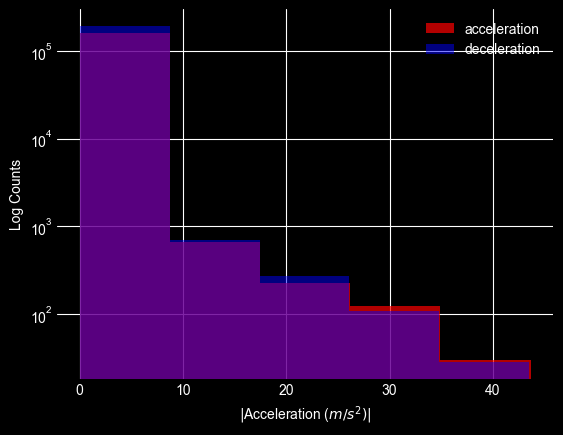

In [28]:
non_null_accelerations = np.delete(all_accelerations, np.where(all_accelerations == 0.0))
negative_accelerations = non_null_accelerations[np.where(non_null_accelerations < 0.0)]
positive_accelerations = non_null_accelerations[np.where(non_null_accelerations > 0.0)]
no_bins = 5
plt.hist(positive_accelerations, bins=no_bins, label='acceleration', color='red', alpha=0.7)
plt.hist(abs(negative_accelerations), bins=no_bins, label='deceleration', color='blue', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.xlabel("$|$Acceleration ($m/s^2)|$")
plt.ylabel("Log Counts")
plt.savefig('deceleration_pref.png', bbox_inches='tight', transparent=True)

plt.show()

Generally, trains tend to decelerate more then they accelerate, this is the opposite if we are talking of high absolute values for accelerations

# Acceleration analysis

In [29]:
# Generic functions
def has_certain_acceleration_values(accelerations, comparing_function):
    for acceleration_value in accelerations:
        if comparing_function(acceleration_value):
            return True
    
    return False


def get_indexes_acceleration_has_certain_values(accelerations, comparing_function):
    np_accelerations = np.array(accelerations)
    return np.where(comparing_function(np_accelerations))[0]


# Functions for speed greater than
def has_acceleration_over_threshold(accelerations, threshold):
    return has_certain_acceleration_values(accelerations, lambda acc: acc >= threshold and acc < MAX_ACCELERATION)


def has_acceleration_error(accelerations, threshold):
    return has_certain_acceleration_values(accelerations, lambda acc: acc >= threshold)


def get_indexes_max_acceleration(acceleration_list):
    return get_indexes_acceleration_has_certain_values(acceleration_list, lambda acc: acc >= MAX_ACCELERATION)


# Functions for speed less than
def has_emergency_braking(accelerations, threshold):
    return has_certain_acceleration_values(accelerations, lambda acc: acc < threshold)


def get_indexed_emergency_braking(accelerations, threshold):
    return get_indexes_acceleration_has_certain_values(accelerations, lambda acc: acc < threshold)

In [30]:
acceleration_error_different_vehicles = []
acceleration_error_same_vehicles = []

for row_index, row in enumerate(df.acceleration.apply(get_indexes_max_acceleration)):
    if row.size > 0:
        for list_index in row:
            tuple = df.loc[row_index]
            if tuple.vehicles_sequence[list_index] == tuple.vehicles_sequence[list_index+1]:
                acceleration_error_same_vehicles.append((row_index, list_index, tuple.vehicles_sequence[list_index], [round(value, 3) for value in tuple.speed_delta[list_index: list_index+2]]))
            else: 
                acceleration_error_different_vehicles.append((row_index, list_index, tuple.vehicles_sequence[list_index:list_index+2], [round(value, 3) for value in tuple.speed_delta[list_index: list_index+2]]))


print(f"Number of acceleration errors but because of vehicle switch: {len(acceleration_error_different_vehicles)}")
print(f"Number of acceleration errors on the same vehicle: {len(acceleration_error_same_vehicles)}")
acceleration_error_same_vehicles

Number of acceleration errors but because of vehicle switch: 831
Number of acceleration errors on the same vehicle: 19


[(381, 768, 1001, [0.0, -10.028]),
 (913, 679, 658, [0.0, -16.028]),
 (913, 680, 658, [-16.028, 15.944]),
 (913, 682, 658, [0.028, -15.972]),
 (913, 729, 658, [0.0, -14.333]),
 (913, 730, 658, [-14.333, 14.333]),
 (913, 741, 658, [-1.861, -7.361]),
 (913, 744, 658, [0.0, 7.361]),
 (913, 766, 658, [0.0, -7.444]),
 (913, 780, 658, [0.0, -7.556]),
 (913, 799, 658, [0.278, -8.083]),
 (913, 801, 658, [0.0, 7.972]),
 (913, 802, 658, [7.972, -7.972]),
 (913, 811, 658, [0.167, -10.306]),
 (913, 813, 658, [0.0, 10.139]),
 (913, 814, 658, [10.139, -10.139]),
 (913, 831, 658, [0.0, 11.194]),
 (913, 832, 658, [11.194, -11.194]),
 (913, 833, 658, [-11.194, 11.167])]

Acceleration errors on the same vehicle happens mostly on the record with index 913

In [31]:
original_df.loc[913]

incident_id                                                               4606441
vehicles_sequence               [658, 658, 658, 658, 658, 658, 658, 658, 595, ...
events_sequence                 [4358, 4336, 4336, 4332, 4336, 2742, 4026, 414...
seconds_to_incident_sequence    [-14208, -14186, -14065, -14029, -13733, -1313...
approx_lat                                                               50.39604
approx_lon                                                               3.535942
train_kph_sequence              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dj_ac_state_sequence            [False, False, False, False, False, False, Fal...
dj_dc_state_sequence            [True, True, True, True, True, True, True, Tru...
incident_type                                                                  11
Name: 913, dtype: object

,incident_type,count,percentage,count_percentage_on_total
0,2,60,40.816327,50.420168
1,3,1,0.680272,20.000000
2,4,20,13.605442,25.641026
3,6,1,0.680272,16.666667
4,7,1,0.680272,25.000000
5,9,14,9.523810,11.965812
6,11,6,4.081633,23.076923
7,13,20,13.605442,6.289308
8,14,11,7.482993,7.382550
9,17,3,2.040816,30.000000


Number of records with high speed: 147


,incident_type,count,percentage,count_percentage_on_total
0,2,60,42.857143,50.420168
1,3,1,0.714286,20.000000
2,4,21,15.000000,26.923077
3,6,1,0.714286,16.666667
4,7,1,0.714286,25.000000
5,9,13,9.285714,11.111111
6,11,7,5.000000,26.923077
7,13,19,13.571429,5.974843
8,14,7,5.000000,4.697987
9,17,3,2.142857,30.000000


Number of records with a speed error: 140


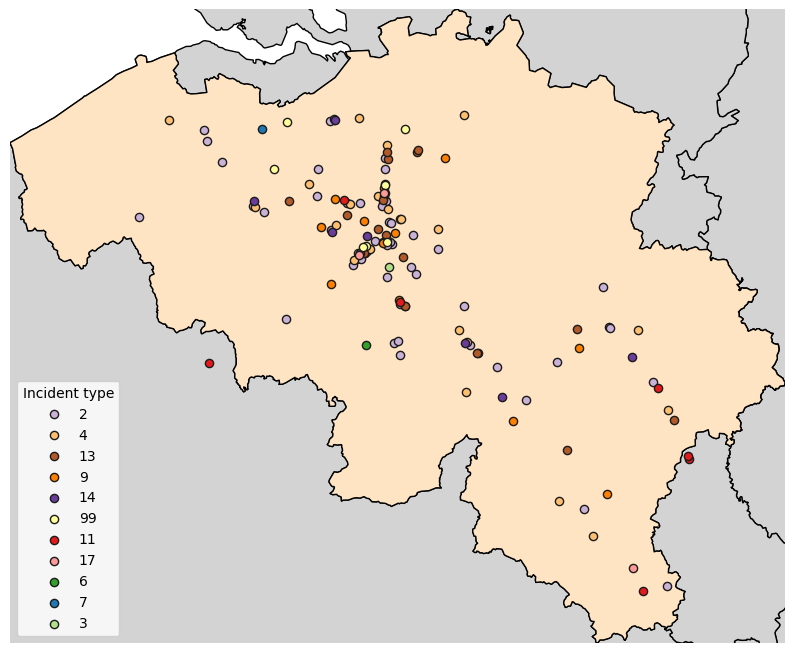

In [32]:
plt.style.use("default")
df_with_high_acceleration = df[df['acceleration'].apply(lambda x: has_acceleration_over_threshold(x, 10))]
df_with_acceleration_error = df[df['acceleration'].apply(lambda x: has_acceleration_error(x, MAX_ACCELERATION))]
display(IS.get_stats_incidents(df_with_high_acceleration))
print(f"Number of records with high speed: {df_with_high_acceleration.shape[0]}")
display(IS.get_stats_incidents(df_with_acceleration_error))
IS.get_geospatial_summary(df_with_acceleration_error)
print(f"Number of records with a speed error: {df_with_acceleration_error.shape[0]}")


There seems to be a relation in the incident type between trains that reach at a certain point high speed and trains that have speed errors!

In [33]:
symmetric_difference = df.loc[list(set(df_with_high_acceleration.index).symmetric_difference((df_with_acceleration_error.index)))]
IS.get_stats_incidents(symmetric_difference)

,incident_type,count,percentage,count_percentage_on_total
0,2,12,34.285714,10.084034
1,4,5,14.285714,6.410256
2,9,1,2.857143,0.854701
3,11,3,8.571429,11.538462
4,13,7,20.000000,2.201258
5,14,4,11.428571,2.684564
6,99,3,8.571429,1.714286


In [34]:
threshold = -15
events_correlated_with_emergency_braking = []

for row_index, row in enumerate(df.acceleration.apply(lambda x: get_indexed_emergency_braking(x, threshold))):
    if row.size > 0:
        for list_index in row:
            tuple = df.loc[row_index]
            events_correlated_with_emergency_braking.extend(tuple.events_sequence[list_index+0:list_index+1])

In [35]:
counts_emergency_braking_events = Counter(events_correlated_with_emergency_braking)
eme_brake_stats = pd.DataFrame.from_dict(counts_emergency_braking_events, orient='index', columns=['counts'])
eme_brake_stats = eme_brake_stats.reset_index(names='event')
eme_brake_stats = eme_brake_stats.merge(event_counts, on='event')
eme_brake_stats['percentage_on_total'] = eme_brake_stats.apply(lambda x: round(x.counts/x.counts_on_total, 3), axis=1)
eme_brake_stats = eme_brake_stats.sort_values(by='percentage_on_total', ascending=False)
display(eme_brake_stats)

,event,counts,counts_on_total,percentage_on_total
2,74,1,6,0.167
4,1446,1,12,0.083
3,1808,1,40,0.025
7,3364,1,169,0.006
0,2956,526,291975,0.002
6,3980,1,462,0.002
1,3982,2,1888,0.001
5,4168,4,6166,0.001
8,4410,1,910,0.001


There seems to be no relation between emergency braking and a particular event.

What about incidents?

,incident_type,count,percentage,count_percentage_on_total
0,2,60,40.000000,50.420168
1,3,1,0.666667,20.000000
2,4,21,14.000000,26.923077
3,7,1,0.666667,25.000000
4,9,14,9.333333,11.965812
5,11,6,4.000000,23.076923
6,13,22,14.666667,6.918239
7,14,12,8.000000,8.053691
8,17,3,2.000000,30.000000
9,99,10,6.666667,5.714286


Number of records with emergency braking: 150


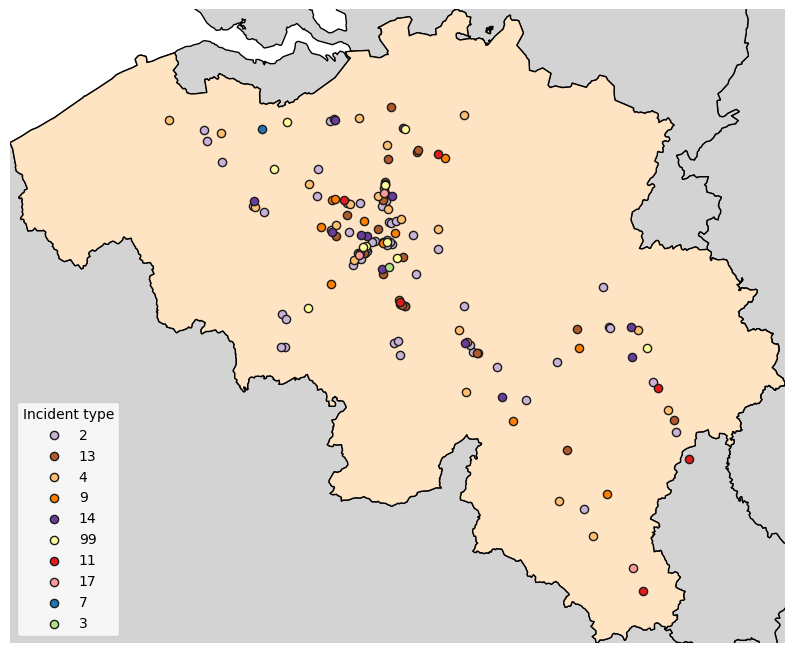

In [36]:
df_with_emergency_braking = df[df['acceleration'].apply(lambda x: has_emergency_braking(x, -10))]
display(IS.get_stats_incidents(df_with_emergency_braking))
IS.get_geospatial_summary(df_with_emergency_braking)
print(f"Number of records with emergency braking: {df_with_emergency_braking.shape[0]}")

,incident_type,count,percentage,count_percentage_on_total
0,2,8,29.629630,6.722689
1,4,5,18.518519,6.410256
2,6,1,3.703704,16.666667
3,11,2,7.407407,7.692308
4,13,6,22.222222,1.886792
5,14,3,11.111111,2.013423
6,99,2,7.407407,1.142857


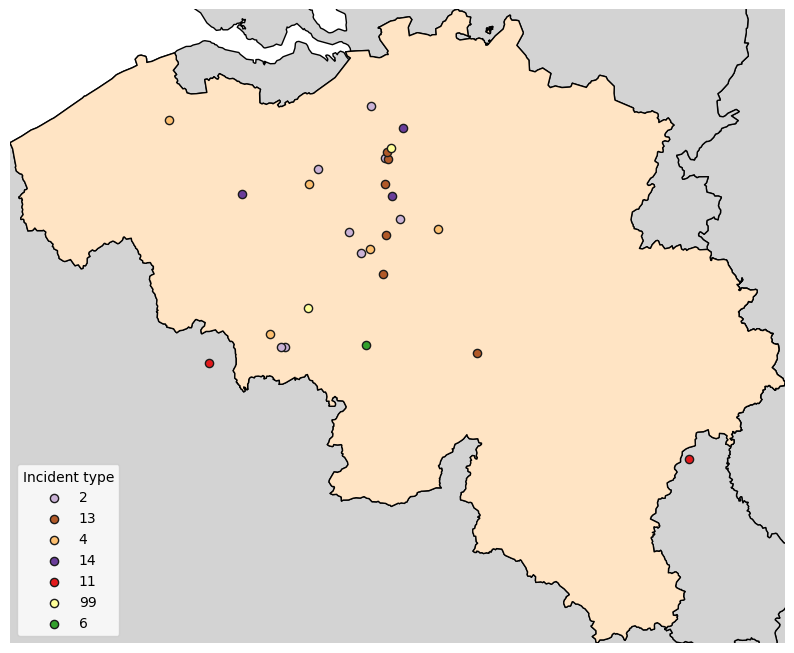

In [37]:
symmetric_difference = df.loc[list(set(df_with_high_acceleration.index).symmetric_difference((df_with_emergency_braking.index)))]
IS.get_geospatial_summary(symmetric_difference)
IS.get_stats_incidents(symmetric_difference)

/tmp/ipykernel_229211/4282705730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_acceleration_error['category'] = 'Acceleration Error'
/tmp/ipykernel_229211/4282705730.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_high_acceleration['category'] = 'High Acceleration'
/tmp/ipykernel_229211/4282705730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

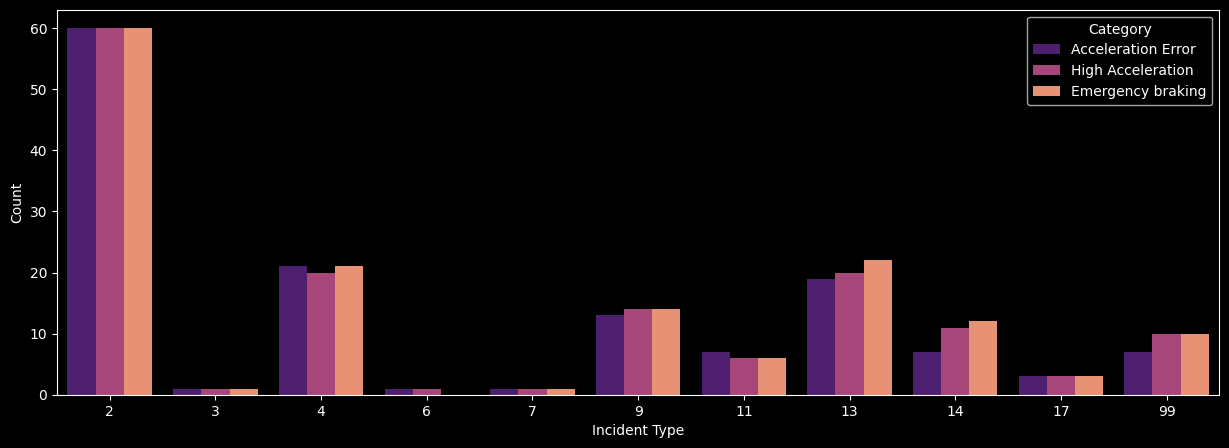

In [38]:
plt.style.use("dark_background")
df_with_acceleration_error['category'] = 'Acceleration Error'
df_with_high_acceleration['category'] = 'High Acceleration'
df_with_emergency_braking['category'] = 'Emergency braking'

combined_df = pd.concat([df_with_acceleration_error, df_with_high_acceleration, df_with_emergency_braking])
plt.figure(figsize=(15, 5))
sns.countplot(combined_df, x='incident_type', hue='category', stat='count', palette='magma')
plt.legend(title="Category")
plt.xlabel("Incident Type")
plt.ylabel("Count")
plt.savefig('acceleration.png', bbox_inches='tight', transparent=True)
plt.show()